# Expression Evaluation (In-Memory)

ironArray has a strong support for expression evaluation.
Things like sums, products, divisions and a pretty complete range of transcendental functions (e.g. `exp`, `sin`, `asin`, `tanh`...)
 have been implemented so as to guarantee an efficient evaluation in (large) arrays.  Performance comes from a balance between:

1. Use of an internal just in time compiler.

2. Use of multi-threading capabilities.

3. Leveraging the 2-level partitioning in ironArray arrays so that most of the computation intensive happens inside private caches (L1, L2),
 which benefits multi-threading performance.

You can access to the powerful evaluation capabilities in ironArray in different ways, which we are going to show in this tutorial.
  In order to do that, we are going to make use of the dataset that we created during our reductions tutorial.  Let's go:

In [1]:
%load_ext memprofiler
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import iarray as ia

Now, in order to evaluate some expressions on this, let's put the data for each month on a different array:

In [2]:
%%mprof_run -i 0.1 load
precip1 = ia.load("precip1.iarr")
precip2 = ia.load("precip2.iarr")
precip3 = ia.load("precip3.iarr")

memprofiler: used 323.66 MiB RAM (peak of 452.96 MiB) in 1.0961 s, total RAM usage 472.21 MiB


Here we can see how the memory is being used during the load process:

In [3]:
%mprof_plot load -t "Memory usage for loading ironArray data"

Note how, even if the data for all the three months takes almost 9 GB uncompressed, ironArray has used less than 1 GB for holding them in RAM.  This is compression at work.

With that, let's compute something easy, like a new array with the mean of these.  For that, we are going to use the internal evaluation engine:

In [4]:
precip_expr = ia.expr_from_string("(p1 + p2 + p3) / 3", {'p1': precip1, 'p2': precip2, 'p3': precip3})

Ok, that was fast, but we did not quite evaluate anything yet.  In order to do the actual evaluation, we have to call `.eval()` on the expression:

In [5]:
%%mprof_run iarray::mean
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

memprofiler: used 1300.86 MiB RAM (peak of 1300.86 MiB) in 5.3018 s, total RAM usage 1801.38 MiB


Cool, so we have our first evaluation done.  But let's see how it performs against NumPy, and especially, whether our outcome is correct:

In [6]:
%%mprof_run
np_precip1 = precip1.data
np_precip2 = precip2.data
np_precip3 = precip3.data

memprofiler: used 8414.47 MiB RAM (peak of 8457.05 MiB) in 9.5888 s, total RAM usage 10215.86 MiB


Here we see how the data takes around 8 ~ 9 GB of RAM.  Now, let's do the actual mean:

In [7]:
%%mprof_run numpy::mean
np_result = (np_precip1 + np_precip2 + np_precip3) / 3

memprofiler: used 969.03 MiB RAM (peak of 969.03 MiB) in 14.5831 s, total RAM usage 11033.87 MiB


So, ironArray times are consideraby faster than NumPy.  In addition, ironArray also uses much less memory data in compressed form by default.

Now, let's use expressions with some transcendental functions.  This does not make sense for this case (precipitation data), but we are doing this just as an indication of the efficiency of the computational engine inside ironArray:

In [8]:
%%mprof_run iarray::trans
result = ia.expr_from_string("(tan(p1) * (sin(p1) * sin(p2) + cos(p2)) + sqrt(p3) * 2)",
                             {'p1': precip1, 'p2': precip2, 'p3': precip3}
                             ).eval()
result

<IArray (720, 721, 1440) np.float32>

memprofiler: used -1396.05 MiB RAM (peak of 134.07 MiB) in 16.7255 s, total RAM usage 9651.60 MiB


In this case we see that the overhead of using transcendental functions is noticeable, but still pretty low. Let's compare this against NumPy:

In [9]:
%%mprof_run numpy::trans
p1_ = np_precip1
p2_ = np_precip2
p3_ = np_precip3
np_result = (np.tan(p1_) * (np.sin(p1_) * np.sin(p2_) + np.cos(p2_)) + np.sqrt(p3_) * 2)

memprofiler: used -5654.63 MiB RAM (peak of 293.42 MiB) in 94.5693 s, total RAM usage 3773.87 MiB


Ok, this has been really slow, but this is kind of expected because, NumPy has to create large temporaries so as to complete the computation. Also, this additional memory consumption can make some machines to use swap space, which can contribute to the slowness as well.  More on memory usage later.

## Lazy expressions

So far we have been using strings as the way to build expressions.  However, there is a handier (and perhaps more elegant) way to build expressions via the so-called lazy expressions.  With lazy expressions you just express your computations in terms of `IArray` objects.

For example, the mean of the precipitation would be expressed as:

In [10]:
%%mprof_run
precip_expr = (precip1 + precip2 + precip3) / 3
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

memprofiler: used 1626.79 MiB RAM (peak of 1626.79 MiB) in 8.0119 s, total RAM usage 5503.93 MiB


Lazy expressions are similar to how you use NumPy to evaluate expressions with some differences:

1. You need to be explicit when you want to `.eval()`-uate the expressions.

2. There are no big temporaries involved.  The expression is compiled on the flight and large temporaries are avoided.  This means not only that we require less memory, but more importantly, that expressions evaluate faster (memory access is always expensive).

For evaluating expressions with transcendental functions you need to use ironArray functions:

In [11]:
%%mprof_run
lazy_expr = ia.tan(precip1) * (ia.sin(precip1) * ia.sin(precip2) + ia.cos(precip2)) + ia.sqrt(precip3) * 2
# You can also use methods, which is not as close to NumPy, but a hair more concise
# lazy_expr = precip1.tan() * (precip1.sin() * precip2.sin() + precip2.cos()) + precip3.sqrt() * 2
lazy_result = lazy_expr.eval()
lazy_result

<IArray (720, 721, 1440) np.float32>

memprofiler: used -637.87 MiB RAM (peak of 0.87 MiB) in 12.5297 s, total RAM usage 4854.75 MiB


Note how execution times and memory usage are very similar to the string expressions evaluator.

As you can see, lazy expressions allow for a more Pythonic way to integrate ironArray operands in expressions, just like NumPy (only more memory efficient and faster).  In general, you can use the method you like the most, although evaluation of string expressions tends to be a hair faster, especially when using small arrays.

## Resource consumption

As a summary, let's do a plot on the speed for the different kind of computations:

In [12]:
%mprof_plot iarray::mean numpy::mean -t "Mean computation"

As we can see, ironArray requires much less memory than NumPy, and it is faster for this case too.

Now let's see the resouce consumption for the transcendental expression:

In [13]:
%mprof_plot iarray::trans numpy::trans -t "Transcendental expression"

The picture is quite different for the transcendental expression.  This time ironArray is *way* faster while consuming *much* less memory.  This is mainly because NumPy uses large temporaries in this case.

## Optimization Tips

Even if ironArray has been very competitive in terms of speed and memory consumption, so far the computations have been done using just the default values.  Let's see how we can accelerate things here, even at the expense of using more memory.

If you remember from the tutorial on reductions, we already reached to kind of 'optimal' chunks for reductions,
so let's use the same configuration:

In [14]:
%%mprof_run
ia.set_config(favor=ia.Favor.SPEED, chunks=(360, 128, 1440), blocks=(8, 8, 720))
precip1_sp = precip1.copy()
precip2_sp = precip2.copy()
precip3_sp = precip3.copy()

memprofiler: used 260.55 MiB RAM (peak of 760.18 MiB) in 18.4769 s, total RAM usage 5064.79 MiB


In [15]:
%%mprof_run iarray::mean_speed
precip_mean = (precip1_sp + precip2_sp + precip3_sp) / 3
precip_mean_speed = precip_mean.eval()

memprofiler: used 1050.75 MiB RAM (peak of 1051.13 MiB) in 4.3182 s, total RAM usage 6115.56 MiB


This is significantly faster than our original computation with ironArray:

In [16]:
%mprof_plot iarray::mean iarray::mean_speed numpy::mean -t "Mean computation"

In general you should expect that favoring `ia.Favor.SPEED` would have a significant effect in accelerating computations, although it might well be situations where this is not the case indeed.

Finally, let's suppose that we want to favor compression ratio for the output, instead of speed.  We can achieve that by asking for just 3 decimals of precision; it should help to favor compression ratio via `ia.Favor.CRATIO` too:

In [17]:
%%mprof_run iarray::mean_cratio

precip_mean = (precip1_sp + precip2_sp + precip3_sp) / 3
# eval but just keep 3 digits in precision (10 bits in mantissa)
precip_mean_cratio = precip_mean.eval(fp_mantissa_bits=10, favor=ia.Favor.CRATIO)

memprofiler: used 500.73 MiB RAM (peak of 500.79 MiB) in 16.6240 s, total RAM usage 6600.00 MiB


In [18]:
%mprof_plot iarray::mean iarray::mean_speed iarray::mean_cratio numpy::mean -t "Mean computation"

Here we saved some hundreds of MBs for performing the operation and hosting the new output.

The nice thing about ironArray is that it lets you dial what you prefer very easily: choose between speed, compression ratio or a balance among the two (the default) at your will.  And it will do this while keeping very good execution times.

### Comparison with numba

Let's finish this section by doing a quick comparsion with numba, which is a well known library for performing efficient computacions with NumPy arrays:

In [19]:
import numba as nb
@nb.jit(nopython=True, parallel=True)
def mean_numba(x, y, z):
    out = np.empty(x.shape, x.dtype)
    for i in nb.prange(len(x)):
        out[i] = (x[i] + y[i] + z[i]) / 3
    return out

# Avoid tracking memory consumption of this object
del np_result

In this example we are enforcing numba to execute outside of the Python interpreter (`nopython=True`) for leveraging the parallelism support in numba (`parallel=True`).

In [20]:
%%mprof_run numba::mean
     
np_result = mean_numba(np_precip1, np_precip2, np_precip3)

memprofiler: used -125.91 MiB RAM (peak of 4195.51 MiB) in 17.0585 s, total RAM usage 5436.48 MiB


In [21]:
%mprof_plot iarray::mean iarray::mean_speed iarray::mean_cratio numba::mean numpy::mean -t "Mean computation"

In this case we see that numba takes less time than NumPy too.  This is because numba is being executed in parallel, and this benefits memory bandwidth in general.  On the other hand, the memory consumption of numba is very close to NumPy (as it should because both are working with uncompressed data).

## Memory consumption analysis

Memory efficiency is critical for ironArray, so let's dig a bit more on the pattern of the memory used for both types of computations.

Measuring memory consumption of a Python code in a notebook is challenging because the Python interpreter may decide to free memory at any time, so it is always better to isolate the code that we want to measure in a standalone script and make use of the `mprof` module that comes with the nice `memory_profiler` package.

Let's start with ironArray:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
cfg: Config(codec=<Codec.LZ4: 1>, clevel=9, favor=<Favor.BALANCE: 0>, filters=[<Filter.SHUFFLE: 1>], fp_mantissa_bits=0, use_dict=False, nthreads=3, eval_method=<Eval.AUTO: 1>, seed=2, random_gen=<RandomGen.MERSENNE_TWISTER: 0>, btune=True, dtype=<class 'numpy.float64'>, store=Store(chunks=None, blocks=None, urlpath=None, mode=b'r', contiguous=False, plainbuffer=False), chunks=None, blocks=None, urlpath=None, mode='r', contiguous=False, plainbuffer=False)
load time -> 2.303
cratio: 12.996
mean time -> 7.339
mean time -> 10.022


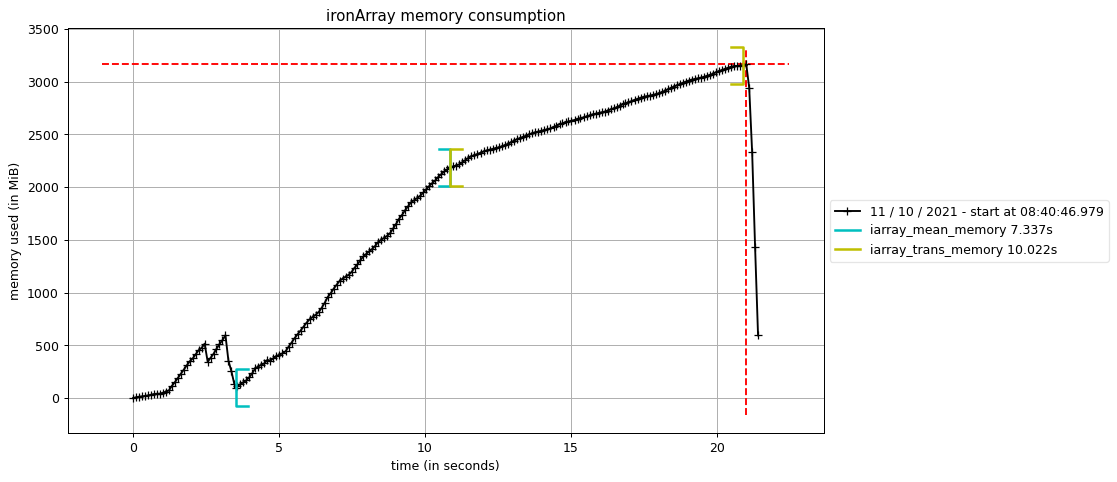

In [22]:
%rm iarray_mean_memory.dat
%run -m mprof run -o iarray_mean_memory.dat iarray_mean_memory.py
%run -m mprof plot iarray_mean_memory.dat -t "ironArray memory consumption"

The first part of the plot is the loading process of the 3 months of precipitation arrays from disk.  This process stops when the 1 GB mark is reached, meaning that the (compressed) data takes that storage in memory.  The part between blue brackets corresponds to the actual mean computation and ~1 GB was needed to host the mean array.  Finally, the yellow brackets show the computation of the transcendental expression (around 1 GB more).  In the end, ironArray has needed a grand total of 3 GB so as to evaluate the *two* expresions.

Now, let's see what is the memory consumption for NumPy:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


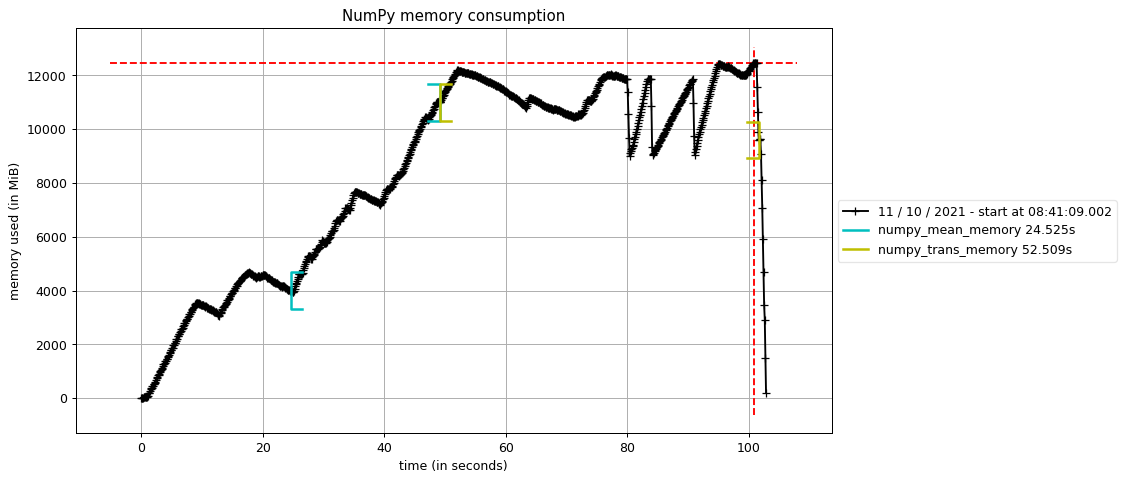

In [23]:
%rm numpy_mean_memory.dat
%run -m mprof run -o numpy_mean_memory.dat numpy_mean_memory.py
%run -m mprof plot numpy_mean_memory.dat -t "NumPy memory consumption"

In this case, the first part of the plot (before the first blue bracket) stops around 8.5 GB (the size of the uncompressed dataset).  The section between blue brackets is where the mean is computed.  In this case, NumPy is well optimized, as it does not seem to use big temporaries (and this is part of the reason on why its computation speed is pretty good).

However, the section for the transcendental evaluation (yellow brackets) shows a more complex pattern, with 2 peaks before reaching the end of the computation.  These peaks clearly correspond to the big temporaries that are needed during the evaluation.  In the end, NumPy has needed around 20 GB so as to evaluate the two expressions.  In comparison, ironArray consumes less than 6x memory for performing the same task.

In general, this means that ironArray can perform operations requiring less memory than using non-compressed arrays, while using a similar time (or much less, like e.g. expressions requiring large temporaries or intermediate function evaluation).

Finally, when we want to minimize the amount of memory during computations, ironArray can also perform evaluations on arrays that are resident on disk (aka out-of-core) in a completely transparent way.  This is the subject of the 'on-disk' counterpart of this tutorial.
